# Workload

This notebook explores using embeddings for generating a workload that should resemble a internet realistic traffic between several countries. Mainly, ground stations that are close to each other should have a similar distribution of requests while ground stations that are far away from each other should have a very different distribution of requests. Additionally, when crossing conutry borders, the distribution of requests should also abruptly change (e.g. cities in Germany that are 20km apart have a more similar distribution of requests than a city in Germany and a city in France that are also 20km apart).

## LLE example

In [1]:
from sklearn.datasets import load_digits
from sklearn.manifold import LocallyLinearEmbedding

Example for an embedding (Locally Linear Embedding) on NIST data set:

In [2]:
X, _ = load_digits(return_X_y=True)

In [3]:
X.shape

(1797, 64)

In [4]:
embedding = LocallyLinearEmbedding(n_components=2)
X_transformed = embedding.fit_transform(X[:500])
X_transformed.shape

(500, 2)

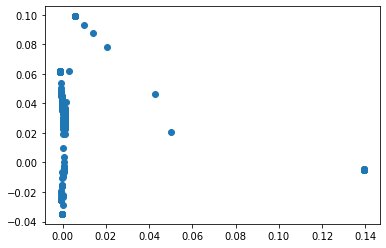

In [5]:
import matplotlib.pyplot as plt
plt.rc('image', cmap='tab10')

fig, ax = plt.subplots()

ax.scatter(x=X_transformed[:,0],y=X_transformed[:,1])

## Data

### Cities

Using coordinates of cities in several European countries as data set for exploration.

In [6]:
import csv
import numpy as np

def read_cities_csv(path):
    dtype = np.dtype([('city', 'str'), ('lat', 'float'), ('long', 'float')])
    with open(path) as f:
        cities = np.array(list(csv.reader(f, delimiter="\t")))
    return cities

Each city is represented by latitude, longitude and a numeric country value.

In [7]:
import os

def load_data(input_dir, filter_keywords=[]):
    files = os.listdir(input_dir)
    X = []
    for i, file in enumerate(files):
        cities = read_cities_csv(os.path.join(input_dir, file))
        
        # Filter cities by keyword, e.g. to remove former colonies
        filter_arr = []
        for name, lat, long in cities:
            if any([(kw in name) for kw in filter_keywords]):
                filter_arr.append(False)
            else:
                filter_arr.append(True)
        cities = cities[filter_arr]
        
        X_i = cities[:,1:]
        X_i = np.c_[X_i, np.full(X_i.shape[0], i)]
        X.append(X_i)
    return np.vstack(X).astype(np.float64)

In [8]:
X = load_data("cities/", filter_keywords=["Reunion", "Réunion", "Cayenne"])

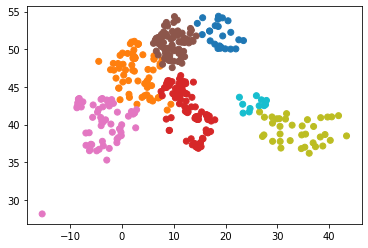

In [9]:
fig, ax = plt.subplots()

ax.scatter(x=X[:,1], y=X[:,0], c=X[:,2])

Normalize coordinates and one-hot-encode country value:

In [10]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

num_cols = [0, 1]
cat_cols = [2]
pipeline = ColumnTransformer([
        ("num_transformer", StandardScaler(), num_cols),
        ("cat_transformer", OneHotEncoder(), cat_cols)
    ])
X = pipeline.fit_transform(X)

In [11]:
one_hot_enc = pipeline.transformers_[1][1]
c = one_hot_enc.inverse_transform(X[:,2:])

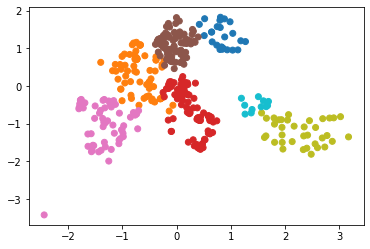

In [12]:
fig, ax = plt.subplots()

ax.scatter(x=X[:,1], y=X[:,0], c=c)

## Embeddings

### LLE

In [13]:
lle = LocallyLinearEmbedding(n_components=2)
X_transformed = lle.fit_transform(X)

LLE does unfortunately not result in a useful embedding as the cities are not evenly distributed and concentrated around small areas:

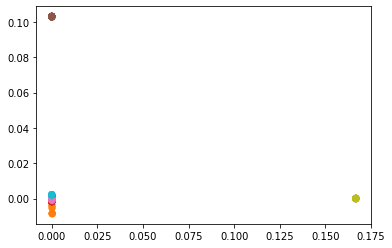

In [14]:
fig, ax = plt.subplots()

ax.scatter(x=X_transformed[:,0], y=X_transformed[:,1], c=c)

### TSNE

Trying out alternative: TSNE

In [15]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
X_transformed_tsne = tsne.fit_transform(X)

Looks very promising, as countries more or less retain their relative distances (e.g. Turkish cities and Bulgarian cities are still close) and differences between countries are accentuated:

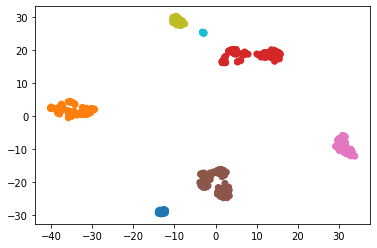

In [16]:
fig, ax = plt.subplots()

ax.scatter(x=X_transformed_tsne[:,0], y=X_transformed_tsne[:,1], c=c)

### UMAP

In [17]:
import umap

reducer = umap.UMAP()

In [18]:
X_transformed_umap = reducer.fit_transform(X)

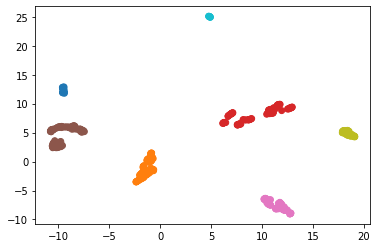

In [19]:
fig, ax = plt.subplots()

ax.scatter(x=X_transformed_umap[:,0], y=X_transformed_umap[:,1], c=c)

## File popularity

### Files grid

To reflect these positions in the popularity of files, the embedding is projected on a "file grid": files are evently distributed over the embedding space and files that are close to a gorund station are very popular there:

In [20]:
xmin = np.min(X_transformed_tsne[:,0])
xmax = np.max(X_transformed_tsne[:,0])

ymin = np.min(X_transformed_tsne[:,1])
ymax = np.max(X_transformed_tsne[:,1])

xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
positions

array([[-40.1554985 , -40.1554985 , -40.1554985 , ...,  33.83536148,
         33.83536148,  33.83536148],
       [-29.73122787, -29.12512061, -28.51901334, ...,  29.06117719,
         29.66728445,  30.27339172]])

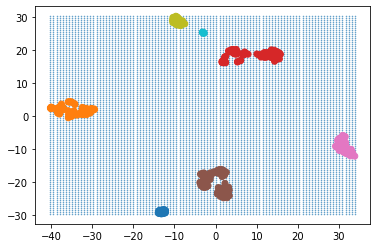

In [21]:
fig, ax = plt.subplots()

ax.scatter(x=positions[0], y=positions[1], s=0.3, alpha=0.7)
ax.scatter(x=X_transformed_tsne[:,0], y=X_transformed_tsne[:,1], c=c)

### Distance to files

In [22]:
def calculate_distance_to_files(gst_coords, files_coords):
    dists = []
    for f_coords in files_coords.T:
        d = np.linalg.norm(gst_coords - f_coords)
        dists.append(d)
    return np.array(dists)

In [23]:
gst_coords = X_transformed_tsne[0][:2]
D = calculate_distance_to_files(gst_coords, positions)

Red files represent files that are popular in the ground station, blue ones are unpopular

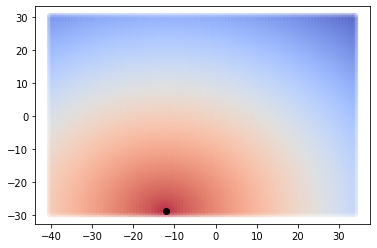

In [24]:
fig, ax = plt.subplots()

ax.scatter(x=positions[0], y=positions[1], c=D, alpha=0.2, cmap="coolwarm_r")
ax.scatter(x=gst_coords[0], y=gst_coords[1], c="black")

The file order will be used for determining which files are popular:

In [25]:
file_order = D.argsort()
D[file_order]

array([ 0.41492587,  0.47536617,  0.49577615, ..., 74.38437561,
       74.40450311, 74.86154242])

In [26]:
file_order

array([3702, 3701, 3802, ..., 9998, 9899, 9999])

## Random distributions

### Zipf (Zeta) distribution

Looks a bit too concentrated around 1 or 2 f

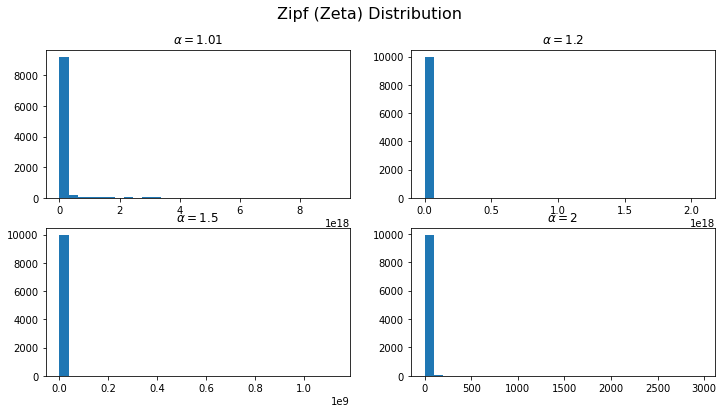

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
params = [1.01, 1.2, 1.5, 2]

fig.suptitle("Zipf (Zeta) Distribution", fontsize=16)
for i, ax in enumerate(axes.flat):
    a = params[i]
    x = np.random.zipf(a, 10000)
    ax.hist(x, bins=30)
    ax.set_title(fr"$\alpha={a}$")

### Geometric distribution

Might resemble realistic internet traffic quite well:

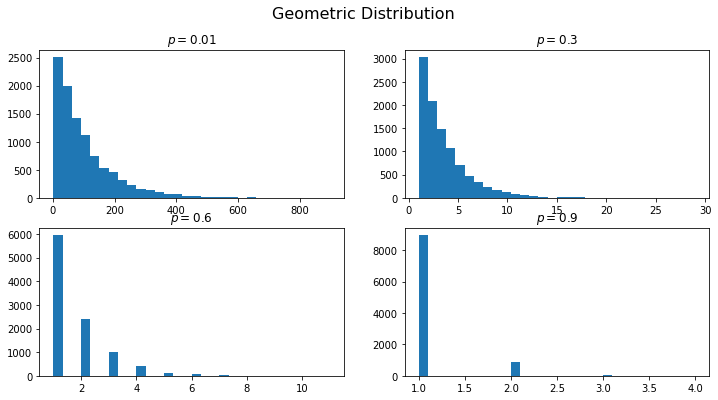

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
params = [0.01, 0.3, 0.6, 0.9]

fig.suptitle("Geometric Distribution", fontsize=16)
for i, ax in enumerate(axes.flat):
    p = params[i]
    x = np.random.geometric(p, 10000)
    ax.hist(x, bins=30)
    ax.set_title(fr"$p={p}$")

## Generalize to 3D case

Since the earth is a globe and not a plane this has to be generalized to the 3D case. In order to do this, the ground stations lat-long (2D) coordinates have to be proected to 3D xyz coordinates.

The embedding would then project from (x, y, z, country) to (a, b, c)